In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
## Additional imports

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import pandas as pd 
from torch.optim.lr_scheduler import StepLR

In [25]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [26]:
epochs = 2000
lr = 1e-3

## Q2 dataloader

the following class reads the data for Q2 and creates a torch dataset object for it. With this, you can easily 
use a dataloader to train your model. 

Make sure that the file "hw2_Q2_data.npz" is located properly (in this example, it should be in the same folder as this notebook.

 



In [27]:
class Q2Data(Dataset):
    def __init__(self,trn_val_tst = 0):
        data = np.load('hw2_Q2_data.npz')
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0'].T
            self.labels = torch.from_numpy(data['arr_1'])
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2'].T
            self.labels = torch.from_numpy(data['arr_3'])
        else:
            #testloader
            self.images = data['arr_4'].T
            self.labels = torch.from_numpy(data['arr_5'])
            
        self.images = torch.from_numpy(np.float32(self.images)/255.0).to(device)
        self.labels= self.labels.to(device)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        return sample, labels

Here is an example of how you can create a dataloader for the Q2 data

In [28]:
trainset =   Q2Data(trn_val_tst=0)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                         shuffle=True, num_workers=0)

valset =   Q2Data(trn_val_tst=1)  
valloader = torch.utils.data.DataLoader(valset, batch_size=100,
                                         shuffle=False, num_workers=0)

testset =   Q2Data(trn_val_tst=2)  
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)

MLP1

In [29]:
class s_mlp(nn.Module):
    def __init__(self, n=32):
        #Call the __init__ function of the parent nn.module class
        super(s_mlp, self).__init__()
        #Define network layers
        
        self.linear1 = nn.Linear(784, n)
        #output of linear2 is 84
        self.linear2 = nn.Linear(n, 10)

            
    def forward(self, x):
        
        out1 = F.relu(self.linear1(x))
        #out1 shape is BatchSize-6-28-28
        out2 = self.linear2(out1)
        #out1 shape is BatchSize-6-14-14

        return out2

In [30]:
loss_fn = nn.CrossEntropyLoss()

In [31]:
def get_model(n = 32, optimizer = "sgd", learn_rate=1e-3):
    model = s_mlp(n).to(device)
    if optimizer == "sgd": 
        opt = optim.SGD(model.parameters(), lr=learn_rate)
    elif optimizer == "adam":
        opt = optim.Adam(model.parameters(), lr=learn_rate)
    return model, opt

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean().item()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, schedule=None):
    if schedule is not None:
        scheduler = StepLR(opt, step_size=schedule, gamma=0.1)
    pbar = tqdm(range(epochs))
    loss_list = []
    acc_list = []
    for epoch in pbar:

        model.train()
        for xb, yb in train_dl:
            tr_loss, tr_num = loss_batch(model, loss_func, xb, yb, opt)
            pred = model(xb)
            tr_acc = accuracy(pred, yb)
    
        model.eval()
        with torch.no_grad():
            for xb, yb in valid_dl:
                losses, nums = loss_batch(model, loss_func, xb, yb)
                pred = model(xb)
                val_acc = accuracy(pred, yb)
                
        if schedule is not None:
            scheduler.step()

        train_loss = np.sum(np.multiply(tr_loss, tr_num)) / np.sum(tr_num)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        loss_list.append([train_loss, val_loss])
        acc_list.append([tr_acc, val_acc])
        pbar.set_description("Epoch %i" % epoch)
        pbar.set_postfix({'Validation loss':val_loss})
    
    return([loss_list, acc_list])

In [32]:
model_32, opt_32 = get_model()

In [ ]:
loss_list_32, acc_list_32 = fit(epochs, model_32, loss_fn, opt_32, trainloader, valloader)

Epoch 180:   9%|████▉                                                 | 181/2000 [01:08<16:32,  1.83it/s, Validation loss=0.685]

In [ ]:
df_32 = pd.DataFrame(loss_list_32, columns =['Training Loss', 'Validation Loss']) 
df_32.plot(title='Q2.1.a - n=32 - Loss')
acc_32 = pd.DataFrame(acc_list_32, columns =['Training Accuracy - 32', 'Validation Accuracy - 32']) 
acc_32.plot(title='Q2.1.a - n=32 - Accuracy')

In [ ]:
model_128, opt_128 = get_model(n=128)
loss_list_128, acc_list_128 = fit(epochs, model_128, loss_fn, opt_128, trainloader, valloader)

In [ ]:
df_128 = pd.DataFrame(loss_list_128, columns =['Training Loss', 'Validation Loss']) 
df_128.plot(title='Q2.1.a - n=128 - Loss')
acc_128 = pd.DataFrame(acc_list_128, columns =['Training Accuracy - 128', 'Validation Accuracy - 128']) 
acc_128.plot(title='Q2.1.a - n=128 - Accuracy')

In [ ]:
model_512, opt_512 = get_model(n=512)
loss_list_512, acc_list_512 = fit(epochs, model_512, loss_fn, opt_512, trainloader, valloader)

In [ ]:
df_512 = pd.DataFrame(loss_list_512, columns =['Training Loss', 'Validation Loss']) 
df_512.plot(title='Q2.1.a - n=512 - Loss')
acc_512 = pd.DataFrame(acc_list_512, columns =['Training Accuracy - 512', 'Validation Accuracy - 512']) 
acc_512.plot(title='Q2.1.a - n=512 - Accuracy')

In [23]:
acc_32.max(axis=0)

Training Accuracy      0.94
Validation Accuracy    0.92
dtype: float64

In [20]:
acc_128.max(axis=0)

Training Accuracy      0.95
Validation Accuracy    0.91
dtype: float64

In [21]:
acc_512.max(axis=0)

Training Accuracy      0.97
Validation Accuracy    0.91
dtype: float64

Learning Rate

<AxesSubplot:title={'center':'Q2.1.b - Fixed Learning Rate 1e-3 - Accuracy'}>

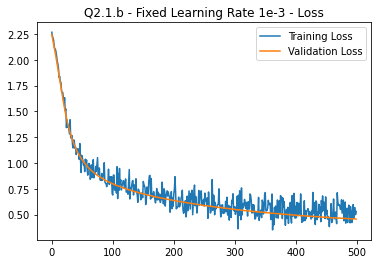

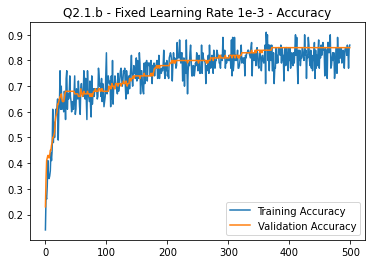

In [29]:
df_32 = pd.DataFrame(loss_list_32, columns =['Training Loss', 'Validation Loss']) 
df_32.plot(title='Q2.1.b - Fixed Learning Rate 1e-3 - Loss')
acc_32 = pd.DataFrame(acc_list_32, columns =['Training Accuracy', 'Validation Accuracy']) 
acc_32.plot(title='Q2.1.b - Fixed Learning Rate 1e-3 - Accuracy')

In [30]:
model_32_lr, opt_32_lr = get_model()
loss_list_lr, acc_list_lr = fit(epochs, model_32_lr, loss_fn, opt_32_lr, trainloader, valloader, schedule=100)

Epoch 499: 100%|███████████████████████████████████████████████████████| 500/500 [02:52<00:00,  2.89it/s, Validation loss=0.767]


<AxesSubplot:title={'center':'Q2.1.b - Decaying LR - Accuracy'}>

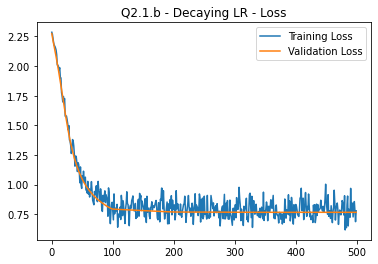

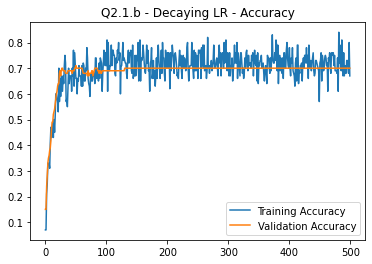

In [31]:
df_lr = pd.DataFrame(loss_list_lr, columns =['Training Loss', 'Validation Loss']) 
df_lr.plot(title='Q2.1.b - Decaying LR - Loss')
acc_lr = pd.DataFrame(acc_list_lr, columns =['Training Accuracy', 'Validation Accuracy']) 
acc_lr.plot(title='Q2.1.b - Decaying LR - Accuracy')

### Question 2 - Deep MLP

In [42]:
class d_mlp(nn.Module):
    def __init__(self, config='a', act_fn='relu'):
        #Call the __init__ function of the parent nn.module class
        super(d_mlp, self).__init__()
        #Define network layers
        
        if config == 'a':
            self.linear1 = nn.Linear(784, 128)
            self.linear2 = nn.Linear(128, 64)
            self.linear3 = nn.Linear(64, 32)
            self.linear4 = nn.Linear(32, 10)
        
        if config == 'b':
            self.linear1 = nn.Linear(784, 32)
            self.linear2 = nn.Linear(32, 64)
            self.linear3 = nn.Linear(64, 128)
            self.linear4 = nn.Linear(128, 10)
        
        if config == 'c':
            self.linear1 = nn.Linear(784, 32)
            self.linear2 = nn.Linear(32, 64)
            self.linear3 = nn.Linear(64, 128)
            self.linear4 = nn.Linear(128, 10)
        
        if act_fn == 'relu':
            self.actfn = nn.ReLU()
        
        if act_fn == 'sigmoid':
            self.actfn = nn.Sigmoid()
    
    def forward(self, x):
        
        out1 = self.actfn(self.linear1(x))
        out2 = self.actfn(self.linear2(out1))
        out3 = self.actfn(self.linear3(out2))
        out4 = self.linear4(out3)

        return out4

In [ ]:
def get_model_deep(config='a', act_fn='relu', learn_rate=lr, optimizer="sgd"):
    model = d_mlp(config).to(device)
    if optimizer == "sgd": 
        opt = optim.SGD(model.parameters(), lr=learn_rate)
    elif optimizer == "adam":
        opt = optim.Adam(model.parameters(), lr=learn_rate)
    return model, opt

In [34]:
model_a, opt_a = get_model_deep(config = 'a', act_fn = 'relu', learn_rate=1e-3)
loss_list_a, acc_list_a = fit(epochs, model_a, loss_fn, opt_a, trainloader, valloader)

Epoch 499: 100%|███████████████████████████████████████████████████████| 500/500 [03:33<00:00,  2.34it/s, Validation loss=0.485]


<AxesSubplot:title={'center':'Q2.2.a - Network A - LR 1e-3 - Accuracy'}>

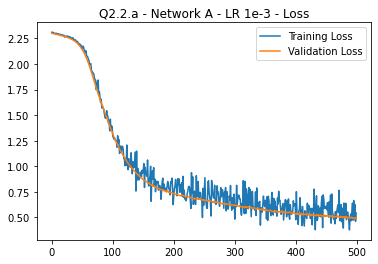

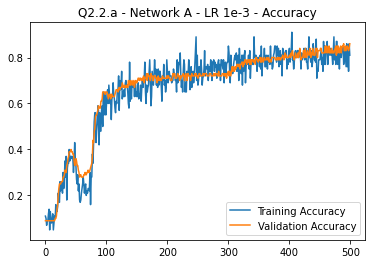

In [35]:
df_a = pd.DataFrame(loss_list_a, columns =['Training Loss', 'Validation Loss']) 
df_a.plot(title='Q2.2.a - Network A - LR 1e-3 - Loss')
acc_a = pd.DataFrame(acc_list_a, columns =['Training Accuracy', 'Validation Accuracy']) 
acc_a.plot(title='Q2.2.a - Network A - LR 1e-3 - Accuracy')

In [36]:
model_b, opt_b = get_model_deep(config = 'b', act_fn = 'relu', learn_rate=1e-3)
loss_list_b, acc_list_b = fit(epochs, model_b, loss_fn, opt_b, trainloader, valloader)

Epoch 499: 100%|████████████████████████████████████████████████████████| 500/500 [03:32<00:00,  2.36it/s, Validation loss=0.51]


<AxesSubplot:title={'center':'Q2.2.b - Network B - LR 1e-3 - Accuracy'}>

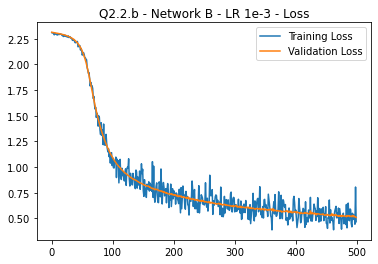

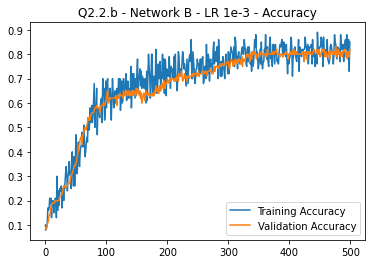

In [37]:
df_b = pd.DataFrame(loss_list_b, columns =['Training Loss', 'Validation Loss']) 
df_b.plot(title='Q2.2.b - Network B - LR 1e-3 - Loss')
acc_b = pd.DataFrame(acc_list_b, columns =['Training Accuracy', 'Validation Accuracy']) 
acc_b.plot(title='Q2.2.b - Network B - LR 1e-3 - Accuracy')

In [38]:
model_c, opt_c = get_model_deep(config = 'c', act_fn = 'relu', learn_rate=1e-3)
loss_list_c, acc_list_c = fit(epochs, model_c, loss_fn, opt_c, trainloader, valloader)

Epoch 499: 100%|████████████████████████████████████████████████████████| 500/500 [03:31<00:00,  2.36it/s, Validation loss=0.52]


<AxesSubplot:title={'center':'Q2.2.c - Network C - LR 1e-3 - Accuracy'}>

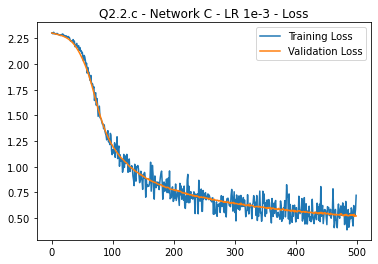

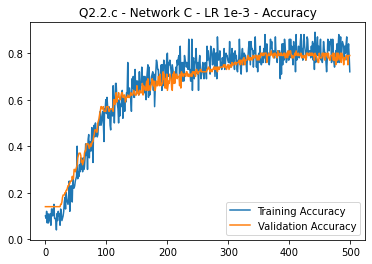

In [39]:
df_c = pd.DataFrame(loss_list_c, columns =['Training Loss', 'Validation Loss']) 
df_c.plot(title='Q2.2.c - Network C - LR 1e-3 - Loss')
acc_c = pd.DataFrame(acc_list_c, columns =['Training Accuracy', 'Validation Accuracy']) 
acc_c.plot(title='Q2.2.c - Network C - LR 1e-3 - Accuracy')


### Question 3 - Sigmoid

In [41]:
acc_a.max(), acc_b.max(), acc_c.max()

(Training Accuracy      0.91
 Validation Accuracy    0.86
 dtype: float64,
 Training Accuracy      0.89
 Validation Accuracy    0.83
 dtype: float64,
 Training Accuracy      0.89
 Validation Accuracy    0.81
 dtype: float64)

Network A yielded the best results

In [43]:
model_sig, opt_sig = get_model_deep(config = 'a', act_fn = 'sigmoid', learn_rate=1e-3)
loss_list_sig, acc_list_sig = fit(epochs, model_sig, loss_fn, opt_sig, trainloader, valloader)

Epoch 499: 100%|███████████████████████████████████████████████████████| 500/500 [03:43<00:00,  2.24it/s, Validation loss=0.513]


In [47]:
df_sig = pd.DataFrame(loss_list_sig, columns =['Sigmoid Training Loss', 'Sigmoid Validation Loss']) 
acc_sig = pd.DataFrame(acc_list_sig, columns =['Sigmoid Training Accuracy', 'Sigmoid Validation Accuracy']) 

loss_q23 = pd.merge(df_a, df_sig, left_index=True, right_index=True)
acc_q23 = pd.merge(acc_a, acc_sig, left_index=True, right_index=True)

In [93]:
reduced_acc = acc_q23[['Validation Accuracy', 'Sigmoid Validation Accuracy']].rename(columns={'Validation Accuracy':'ReLU Validation Accuracy'})

<AxesSubplot:title={'center':'Q2.3 - Accuracy'}>

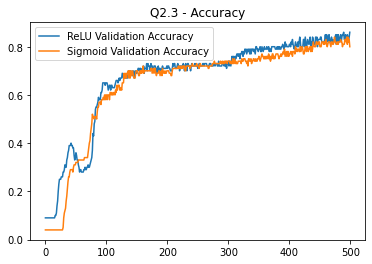

In [94]:
#loss_q23.plot(title='Q2.3 - Loss')
reduced_acc.plot(title='Q2.3 - Accuracy')


### Question 4 - ADAM Optimizer

In [81]:
model_adam, opt_adam = get_model_deep(config = 'a', optimizer = 'adam', learn_rate=1e-4)
loss_list_adam, acc_list_adam = fit(150, model_adam, loss_fn, opt_adam, trainloader, valloader)

Epoch 149: 100%|███████████████████████████████████████████████████████| 150/150 [01:35<00:00,  1.57it/s, Validation loss=0.397]


In [82]:
model_adam_shallow, opt_adam_shallow = get_model(optimizer = 'adam', learn_rate=1e-4)
loss_list_adam_shallow, acc_list_adam_shallow = fit(150, model_adam_shallow, loss_fn, opt_adam_shallow, trainloader, valloader)

Epoch 149: 100%|███████████████████████████████████████████████████████| 150/150 [01:04<00:00,  2.34it/s, Validation loss=0.373]


In [83]:
df_q24a_deep = pd.DataFrame(loss_list_adam, columns =['ADAM Training Loss', 'ADAM Validation Loss']) 
acc_q24a_deep = pd.DataFrame(acc_list_adam, columns =['ADAM Training Accuracy', 'ADAM Validation Accuracy']) 

df_q24a_shallow = pd.DataFrame(loss_list_adam_shallow, columns =['ADAM Training Loss', 'ADAM Validation Loss']) 
acc_q24a_shallow = pd.DataFrame(acc_list_adam_shallow, columns =['ADAM Training Accuracy', 'ADAM Validation Accuracy']) 

In [84]:
loss_q24a = pd.merge(df_q24a_deep, df_a, left_index=True, right_index=True)
acc_q24a = pd.merge(acc_q24a_deep, acc_a, left_index=True, right_index=True)

loss_q24b = pd.merge(df_q24a_shallow, df_32, left_index=True, right_index=True)
acc_q24b = pd.merge(acc_q24a_shallow, acc_32, left_index=True, right_index=True)

<AxesSubplot:title={'center':'Q2.3 - Accuracy - Shallow'}>

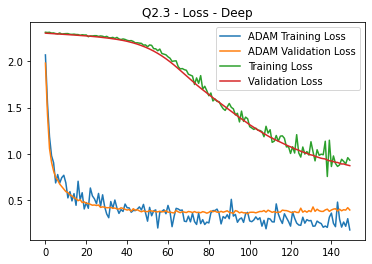

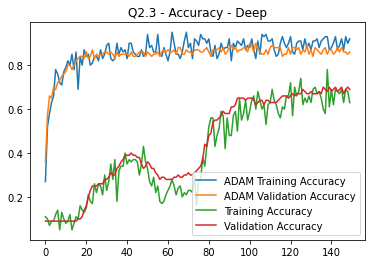

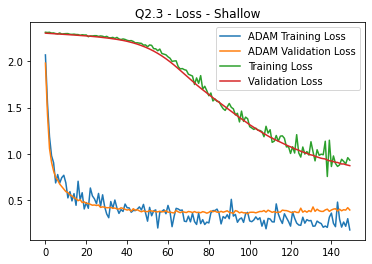

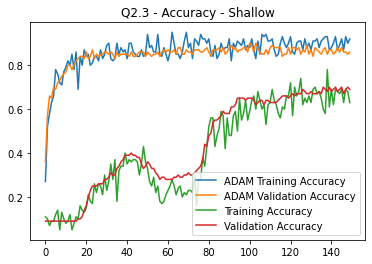

In [95]:
loss_q24a.plot(title='Q2.3 - Loss - Deep')
acc_q24a.plot(title='Q2.3 - Accuracy - Deep')
loss_q24a.plot(title='Q2.3 - Loss - Shallow')
acc_q24a.plot(title='Q2.3 - Accuracy - Shallow')